In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdt
import random

from grid import Microgrid
from agents import MLAgent

from stable_baselines3 import A2C

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_parquet('./data/power_price.parquet')
df = df.dropna()
days = df['time'].dt.date.unique()

In [3]:
def simpleAlgo(state):
    t, batt, price, sol, hydro = state
    return np.array([1, (1 - price)*2-1])


In [4]:
df = pd.read_csv('data/HOLLISTR_1_N101.csv')
df = df[['INTERVALSTARTTIME_GMT', 'MW', 'LMP_TYPE']]
df = df[df['LMP_TYPE'] == 'LMP']
df.drop(columns=['LMP_TYPE'], inplace=True)
df.reset_index(inplace=True, drop=True)
df.columns = ['dt', 'MW']
df['dt'] = pd.to_datetime(df['dt'].str.slice(0, -6).str.replace('T', ' '))
df

pv = pd.read_csv('data/pv_power.csv')
pv.columns = ['dt', 'power']
pv['dt'] = pd.to_datetime(pv['dt'].str.slice(0, 19))
pv

df = df.join(pv.set_index('dt'), on='dt')
df = df.iloc[:df.index[df.power.isna()].min()]

In [5]:
# df['power'] = 0.4
# # df['MW'] = 100 * (df['dt'].dt.hour >= 2)
# df['MW'] = np.random.normal(0, 1, len(df))
# df

In [6]:
env = Microgrid()
env.reset(df)

agent = MLAgent()
agent.load_history(df.set_index('dt')[['MW']])

In [7]:
# model = A2C('MlpPolicy', env, verbose=0)
# m = model.learn(total_timesteps=28800)

In [8]:
episodes = 10
# env.verbose = True
for ep in range(episodes):
    seed = random.randint(0, 1e9)

    # state, info = env.reset(seed=seed)
    # done = False
    # score_model = 0
    # while not done:
    #     action, state = model.predict(state)
    #     state, reward, done, trunc, info = env.step(action)
    #     score_model += reward
    
    state, info = env.reset(seed=seed)
    done = False
    score_algo = 0
    while not done:
        action = simpleAlgo(state)
        state, reward, done, trunc, info = env.step(action)
        score_algo += reward
    
    state, info = env.reset(seed=seed)
    agent.reset(info)
    done = False
    score_agent = 0
    while not done:
        action = agent.predict(state)
        state, reward, done, trunc, info = env.step(action)
        score_agent += reward
    print(f'Episode {ep+1}: ',
          f'score_algo {score_algo},',
          f' score_agent {score_agent}')

Episode 1:  score_algo -460.57484355819247,  score_agent -186.33414360251385
Episode 2:  score_algo -957.0327168415425,  score_agent -198.98239936569405
Episode 3:  score_algo -464.10353357105095,  score_agent -95.78237786820489
Episode 4:  score_algo -680.3561246028831,  score_agent -385.6234650736211
Episode 5:  score_algo -987.869073468571,  score_agent -677.4591042631929
Episode 6:  score_algo -752.8078297678181,  score_agent -258.6912619819931
Episode 7:  score_algo -750.0667201836642,  score_agent -351.1989323679236
Episode 8:  score_algo -791.4452756972247,  score_agent -479.2913211386264
Episode 9:  score_algo -736.0206900253385,  score_agent -237.11946313310054
Episode 10:  score_algo -681.5584250791701,  score_agent 227.37074960438724


In [9]:
seed = random.randint(0, 1e9)
    
state, info = env.reset(seed=seed)
done = False
score_algo = 0
algo_hydro = []
algo_batt = []
algo_stor = []
algo_rew = []
algo_h = []
while not done:
    action = simpleAlgo(state)
    state, reward, done, trunc, info = env.step(action)
    score_algo += reward
    if not done:
        algo_rew.append(reward)
    algo_hydro.append(action[0])
    algo_batt.append(action[1])
    algo_stor.append(state[1])
    algo_h.append(state[4])

state, info = env.reset(seed=seed)
agent.reset(info)
done = False
score_agent = 0
agent_hydro = []
agent_batt = []
agent_stor = []
agent_rew = []
agent_h = []
while not done:
    action = agent.predict(state)
    state, reward, done, trunc, info = env.step(action)
    score_agent += reward
    if not done:
        agent_rew.append(reward)
    agent_hydro.append(action[0])
    agent_batt.append(action[1])
    agent_stor.append(state[1])
    agent_h.append(state[4])
#score_model {score_model},\
print(f'Episode {ep+1}: ',
        f'score_algo {score_algo},',
        f' score_agent {score_agent}')

Episode 10:  score_algo -356.7490484015953,  score_agent -181.8064422728469


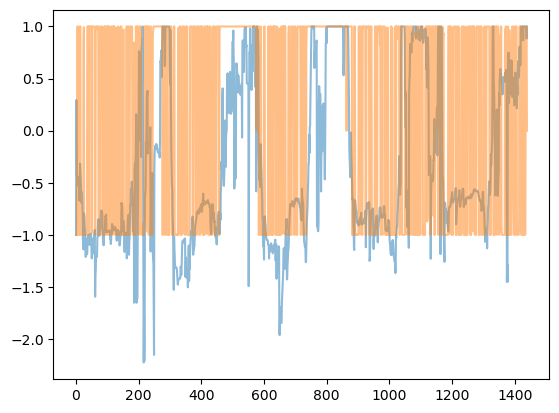

In [17]:
plt.plot(algo_batt, alpha=0.5)
plt.plot(agent_batt, alpha=0.5)

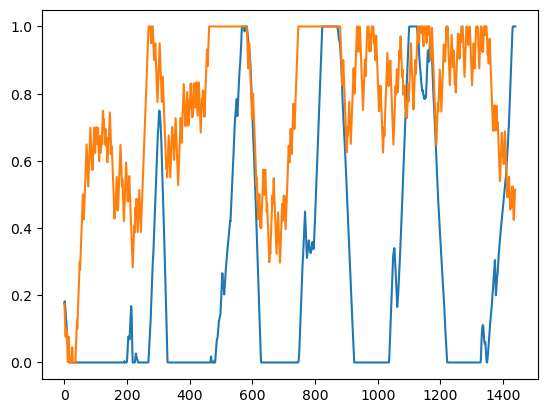

In [12]:
plt.plot(algo_stor)
plt.plot(agent_stor)

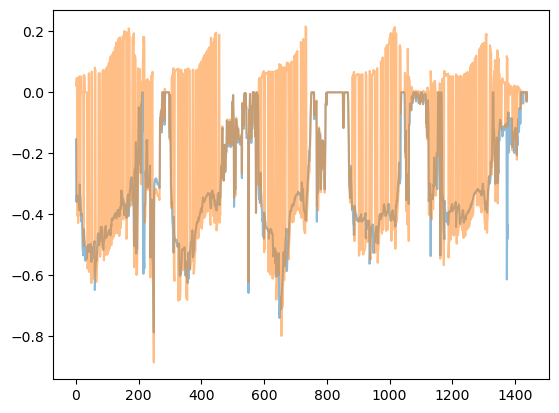

In [18]:
plt.plot(algo_rew, alpha=0.5)
plt.plot(agent_rew, alpha=0.5)

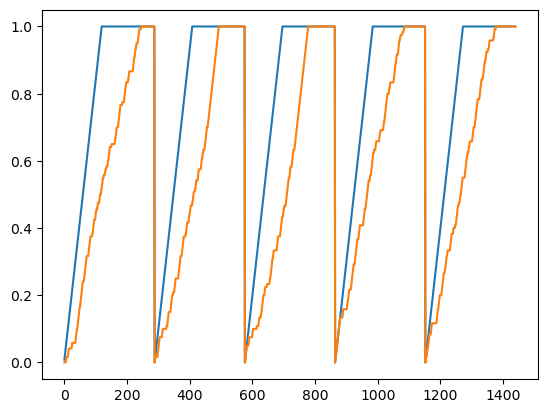

In [16]:
plt.plot(algo_h)
plt.plot(agent_h)